In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime
import matplotlib.colors 
import matplotlib.dates as mdates
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from folium import plugins
import matplotlib.colors
from shapely.geometry import mapping


# Ignore all warnings
warnings.filterwarnings('ignore')


## EDA

---

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..')) 
processed_DPW_path = os.path.join(project_root, 'data', 'processed', 'DPW_data_r3y.csv')

df = pd.read_csv(processed_DPW_path)

In [ ]:
## Check the data imported correctly
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40606 entries, 0 to 40605
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                40606 non-null  int64  
 1   group_id           40606 non-null  int64  
 2   num_requests       40606 non-null  int64  
 3   parent_closed      40606 non-null  object 
 4   status_name        40606 non-null  object 
 5   status_code        40606 non-null  int64  
 6   dept               40606 non-null  object 
 7   request_type_name  40606 non-null  object 
 8   request_type_id    40606 non-null  int64  
 9   create_date_et     40606 non-null  object 
 10  create_date_utc    40606 non-null  object 
 11  last_action_et     40606 non-null  object 
 12  last_action_utc    40606 non-null  object 
 13  closed_date_et     38598 non-null  object 
 14  closed_date_utc    38598 non-null  object 
 15  origin             40606 non-null  object 
 16  street             400

---

1. CASE AND TIME

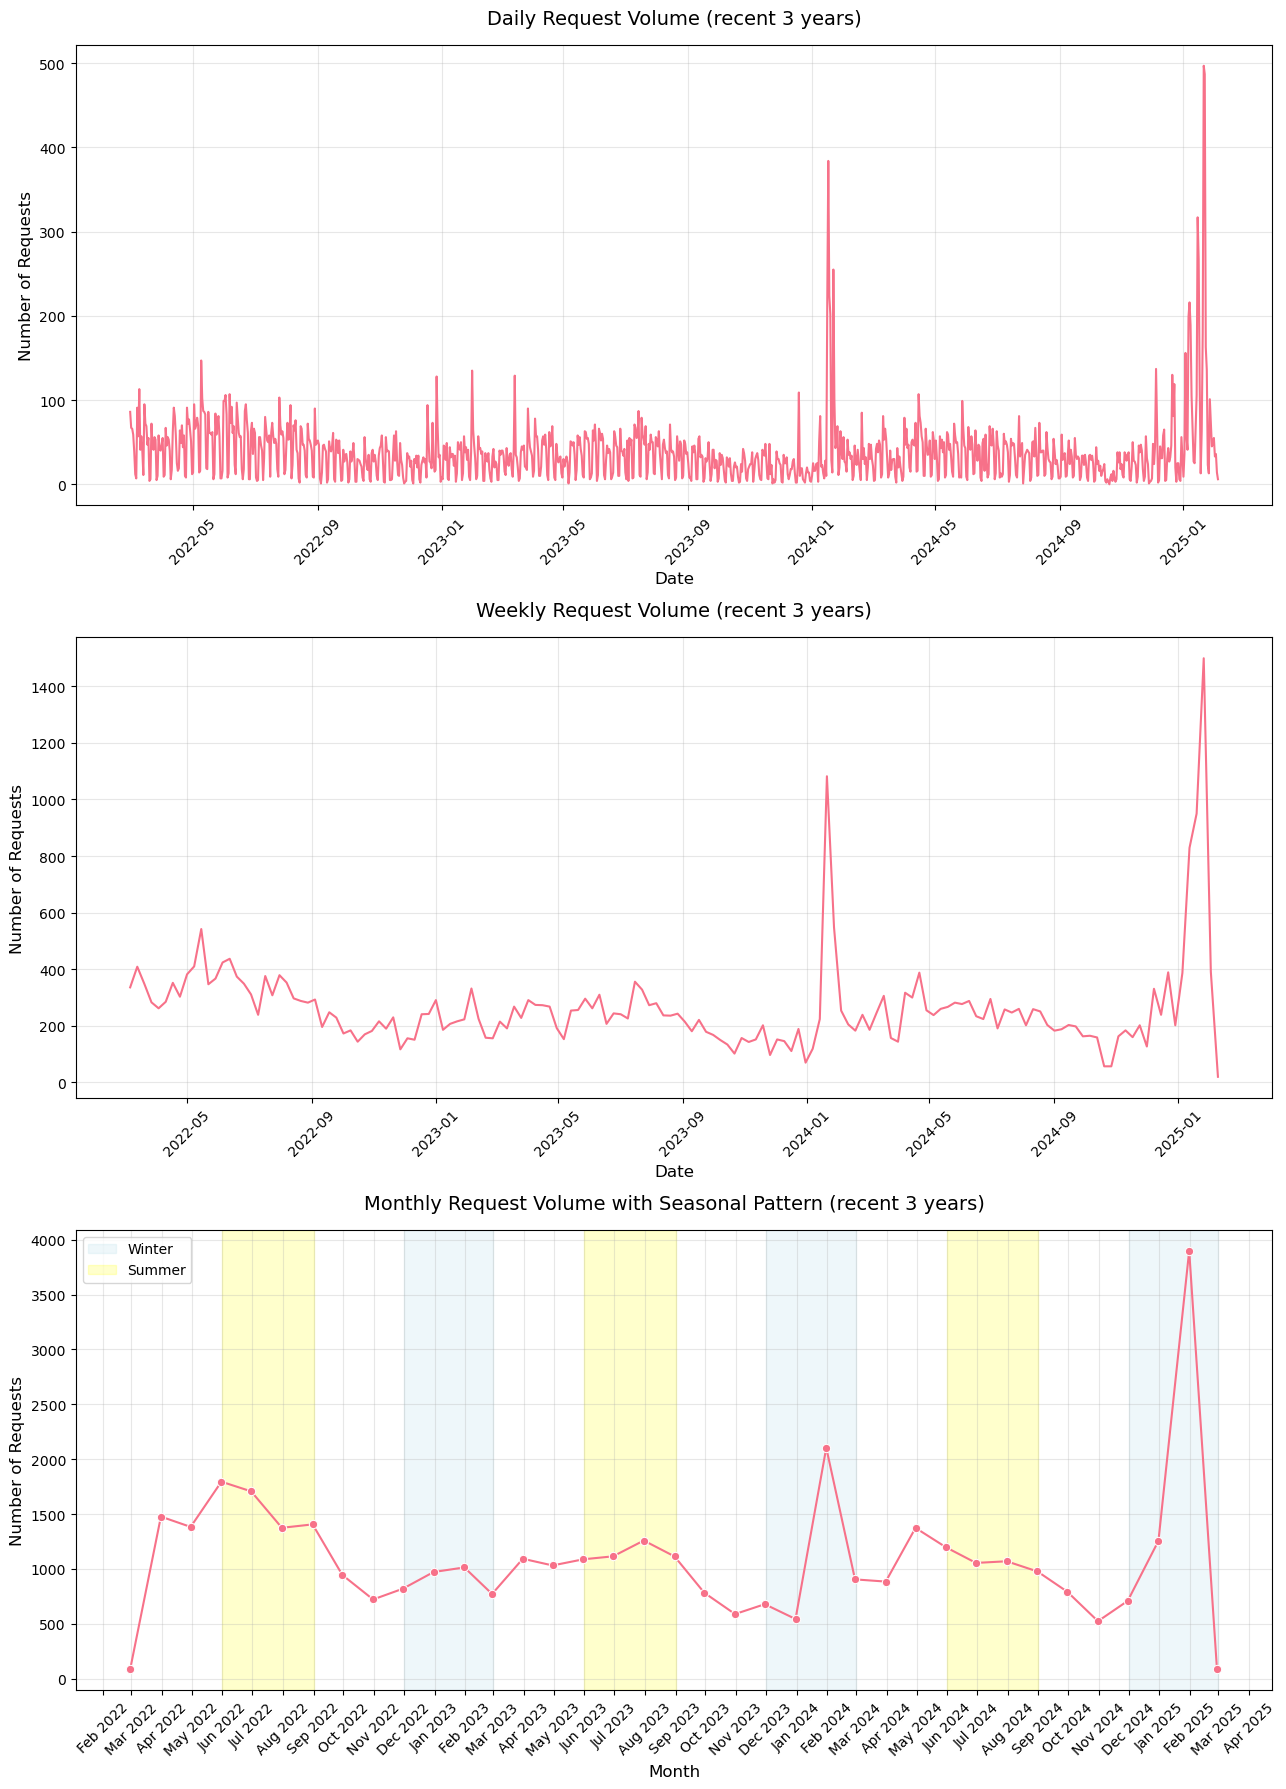


Summary Statistics:

Daily Statistics:
count    1073.000000
mean       37.843430
std        38.709568
min         0.000000
25%        12.000000
50%        33.000000
75%        50.000000
max       497.000000
dtype: float64

Weekly Statistics:
count     154.000000
mean      263.675325
std       165.895584
min        20.000000
25%       184.000000
50%       239.000000
75%       294.500000
max      1499.000000
dtype: float64

Monthly Statistics:
count      37.000000
mean     1097.459459
std       627.615974
min        86.000000
25%       783.000000
50%      1032.000000
75%      1259.000000
max      3899.000000
dtype: float64


In [5]:
# Set basic plot style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13, 18))

# Ensure create_date_et is datetime
df['create_date_et'] = pd.to_datetime(df['create_date_et'])

# 1. Daily Request Count
daily_counts = df.groupby(pd.Grouper(key='create_date_et', freq='D')).size()

sns.lineplot(data=daily_counts, ax=ax1)
ax1.set_title('Daily Request Volume (recent 3 years)', fontsize=14, pad=15)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Number of Requests', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Weekly Request Count
weekly_counts = df.groupby(pd.Grouper(key='create_date_et', freq='W')).size()

sns.lineplot(data=weekly_counts, ax=ax2)
ax2.set_title('Weekly Request Volume (recent 3 years)', fontsize=14, pad=15)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Number of Requests', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Monthly Average with Seasonal Pattern
monthly_counts = df.groupby(pd.Grouper(key='create_date_et', freq='M')).size()

sns.lineplot(data=monthly_counts, ax=ax3, marker='o')
ax3.set_title('Monthly Request Volume with Seasonal Pattern (recent 3 years)', fontsize=14, pad=15)
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Number of Requests', fontsize=12)
ax3.grid(True, alpha=0.3)

# Format x-axis to show months
ax3.xaxis.set_major_locator(mdates.MonthLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax3.tick_params(axis='x', rotation=45)

# Add seasonal backgrounds to monthly plot
for year in [2022, 2023, 2024]:
    # Winter (Dec-Feb)
    ax3.axvspan(datetime(year, 12, 1), datetime(year+1, 3, 1), alpha=0.2, color='lightblue', label='Winter' if year == 2023 else "")
    # Summer (Jun-Aug)
    ax3.axvspan(datetime(year, 6, 1), datetime(year, 9, 1), alpha=0.2, color='yellow', label='Summer' if year == 2023 else "")

ax3.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("\nDaily Statistics:")
print(daily_counts.describe())
print("\nWeekly Statistics:")
print(weekly_counts.describe())
print("\nMonthly Statistics:")
print(monthly_counts.describe())

2. SERVICE TYPE EXPLORATION

In [6]:
# 1. Top Request Types Analysis
df['request_type_name'].value_counts()

request_type_name
Potholes                                11642
Litter, Public Property                  6497
Snow/Ice removal                         6320
Overgrowth                               3371
Street Cleaning/Sweeping                 3295
                                        ...  
HACP                                        1
Small Cell/Telecommunication Antenna        1
Dumpster                                    1
Flooding                                    1
Brick or Block Repair                       1
Name: count, Length: 65, dtype: int64

Top 15 Request Types by Frequency:
request_type_name
Potholes                       11642
Litter, Public Property         6497
Snow/Ice removal                6320
Overgrowth                      3371
Street Cleaning/Sweeping        3295
Litter Can, Public              1613
Tree Fallen Across Road         1118
Drainage/Leak                    929
Public Right of Way              921
Leaves/Street Cleaning           880
City Steps, Need Cleared         726
Salt Box                         646
Barricades                       629
Tree Fallen Across Sidewalk      539
Trail Maintenance                427
Name: count, dtype: int64

Percentage of Total Requests:
request_type_name
Potholes                       28.67
Litter, Public Property        16.00
Snow/Ice removal               15.56
Overgrowth                      8.30
Street Cleaning/Sweeping        8.11
Litter Can, Public              3.97
Tree Fallen Across Road         2.75
Drainage/Leak                   2.29
Public Right of Way  

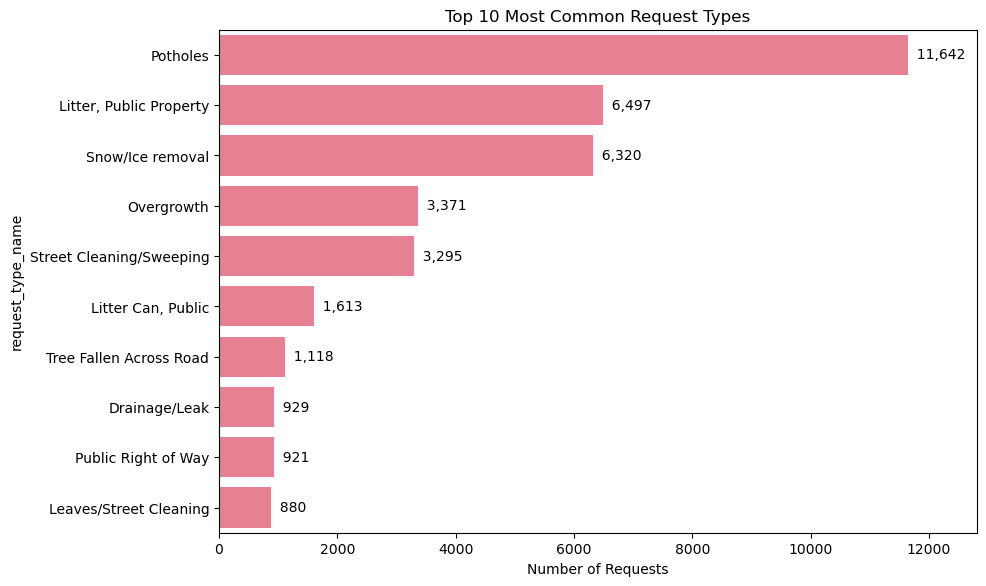

In [7]:
# 1. Top Request Types Analysis
request_type_counts = df['request_type_name'].value_counts()

# Display top 15 request types
print("Top 15 Request Types by Frequency:")
print(request_type_counts.head(15))
print("\nPercentage of Total Requests:")
print((request_type_counts.head(15) / len(df) * 100).round(2), "%")

# Visualize top 10 request types
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=request_type_counts.head(10).values, 
                 y=request_type_counts.head(10).index)

# Add value labels on the bars
for i, v in enumerate(request_type_counts.head(10).values):
    ax.text(v, i, f'  {v:,}', va='center')

plt.title('Top 10 Most Common Request Types')
plt.xlabel('Number of Requests')
plt.xlim(0, max(request_type_counts.head(10).values) * 1.1)  # Add 10% padding
plt.tight_layout()
plt.tight_layout(pad=1.2)
plt.show()


Top 10 Request Types with Highest Average Resolution Times (in hours):
                                  count     mean   median      std
request_type_name                                                 
Homeless                              6  2682.13  2329.37  2197.79
Weeds/Debris                         19  1384.35   239.77  2685.56
Overgrowth                         3248  1052.31   461.48  1726.42
Curb/Request for Asphalt Windrow    324   974.38   267.60  1722.55
Public Right of Way                 832   968.47   239.15  2239.66
Potholes (DO NOT USE)                15   963.80   161.43  2516.97
Port A Potty                        256   856.01   145.81  2017.85
Trail Maintenance                   367   790.18   139.37  2036.38
City Steps, Need Cleared            679   764.15   238.72  1746.98
Refuse Violations                    15   732.81   340.75   802.92


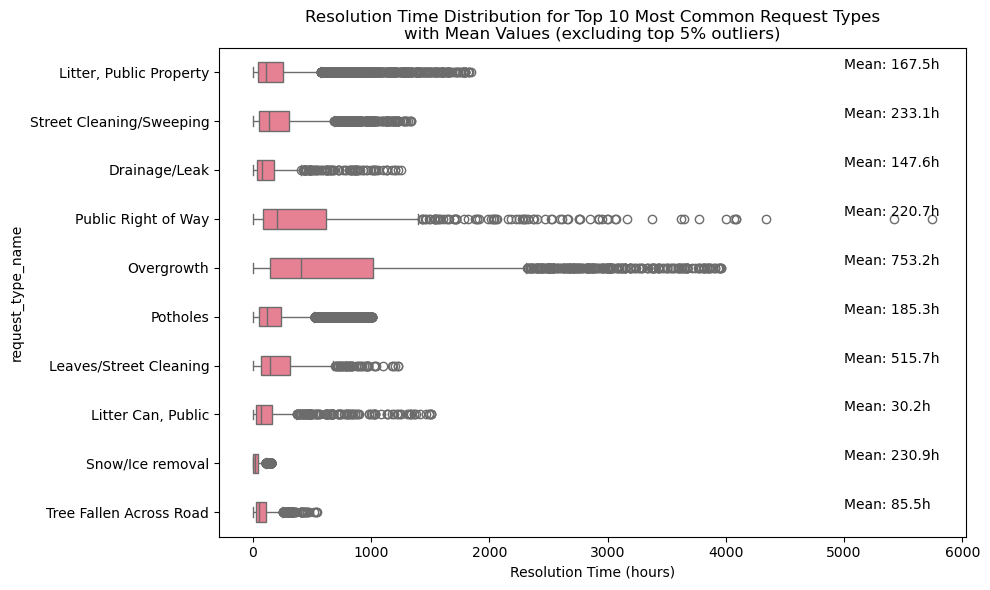


Mean Resolution Times (excluding top 5% outliers):
Drainage/Leak: 167.5 hours (n=775)
Leaves/Street Cleaning: 233.1 hours (n=801)
Litter Can, Public: 147.6 hours (n=1391)
Litter, Public Property: 220.7 hours (n=5699)
Overgrowth: 753.2 hours (n=3085)
Potholes: 185.3 hours (n=10726)
Public Right of Way: 515.7 hours (n=790)
Snow/Ice removal: 30.2 hours (n=5931)
Street Cleaning/Sweeping: 230.9 hours (n=2975)
Tree Fallen Across Road: 85.5 hours (n=1042)


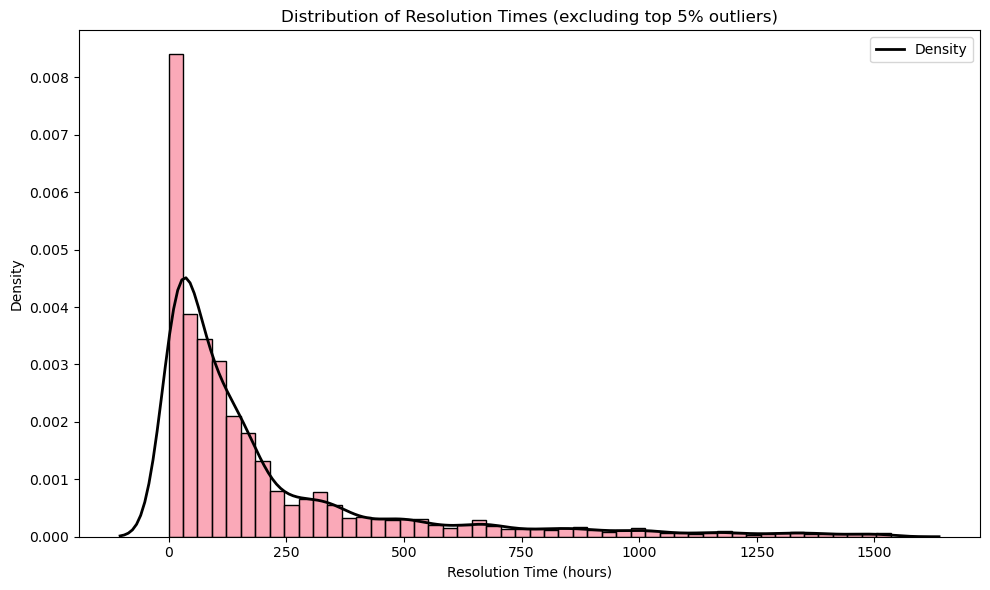

In [8]:
# 2. Resolution Time Analysis
# Create resolution time column (in hours)
df['create_date_et'] = pd.to_datetime(df['create_date_et'])
df['closed_date_et'] = pd.to_datetime(df['closed_date_et'])

# Calculate resolution time for closed requests
mask = (df['closed_date_et'].notna()) & (df['create_date_et'].notna())
df.loc[mask, 'resolution_time'] = (
    df.loc[mask, 'closed_date_et'] - 
    df.loc[mask, 'create_date_et']
).dt.total_seconds() / 3600  # Convert to hours

# Calculate average resolution time by request type
resolution_by_type = df[df['resolution_time'].notna()].groupby('request_type_name').agg({
    'resolution_time': ['count', 'mean', 'median', 'std']
}).round(2)

resolution_by_type.columns = ['count', 'mean', 'median', 'std']
resolution_by_type = resolution_by_type.sort_values('mean', ascending=False)

print("\nTop 10 Request Types with Highest Average Resolution Times (in hours):")
print(resolution_by_type.head(10))
# Get top 10 request types and their resolution times
plt.figure(figsize=(10, 6))
top_10_types = request_type_counts.head(10).index

# Filter out top 5% outliers for each request type
filtered_data = df.copy()
for request_type in top_10_types:
    mask = filtered_data['request_type_name'] == request_type
    threshold = filtered_data[mask]['resolution_time'].quantile(0.95)
    filtered_data.loc[mask & (filtered_data['resolution_time'] > threshold), 'resolution_time'] = None

# Create box plot for resolution times with filtered data
ax = sns.boxplot(data=filtered_data[filtered_data['request_type_name'].isin(top_10_types)],
            x='resolution_time',
            y='request_type_name',
            whis=1.5,
            width=0.4)  # Set whiskers to 1.5 IQR

# Calculate means for each request type (using filtered data)
means = filtered_data[filtered_data['request_type_name'].isin(top_10_types)].groupby('request_type_name')['resolution_time'].mean()

# Add mean values
for i, mean_val in enumerate(means):
    # Get the maximum x value for this box
    box_max = filtered_data[filtered_data['request_type_name'] == means.index[i]]['resolution_time'].quantile(0.75)
    
    # Add text showing the mean value above the box, further to the right
    plt.text(5000, i , f'Mean: {mean_val:.1f}h', 
             verticalalignment='bottom',
             horizontalalignment='left',
             color='black')

plt.title('Resolution Time Distribution for Top 10 Most Common Request Types\nwith Mean Values (excluding top 5% outliers)')
plt.xlabel('Resolution Time (hours)')

# Adjust layout to prevent text cutoff
plt.tight_layout()
plt.show()

# Print the actual mean values and sample sizes
print("\nMean Resolution Times (excluding top 5% outliers):")
for request_type in means.index:
    n_requests = len(filtered_data[
        (filtered_data['request_type_name'] == request_type) & 
        (filtered_data['resolution_time'].notna())
    ])
    print(f"{request_type}: {means[request_type]:.1f} hours (n={n_requests})")


# Additional visualization: Resolution time distribution with KDE line
plt.figure(figsize=(10, 6))

# Create histogram
sns.histplot(data=df[df['resolution_time'] < df['resolution_time'].quantile(0.95)],
             x='resolution_time',
             bins=50,
             stat='density',  # Normalize for density plot
             alpha=0.6)  # Make histogram slightly transparent

# Add KDE line
sns.kdeplot(data=df[df['resolution_time'] < df['resolution_time'].quantile(0.95)],
            x='resolution_time',
            color='Black',
            linewidth=2,
            label='Density')

plt.title('Distribution of Resolution Times (excluding top 5% outliers)')
plt.xlabel('Resolution Time (hours)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

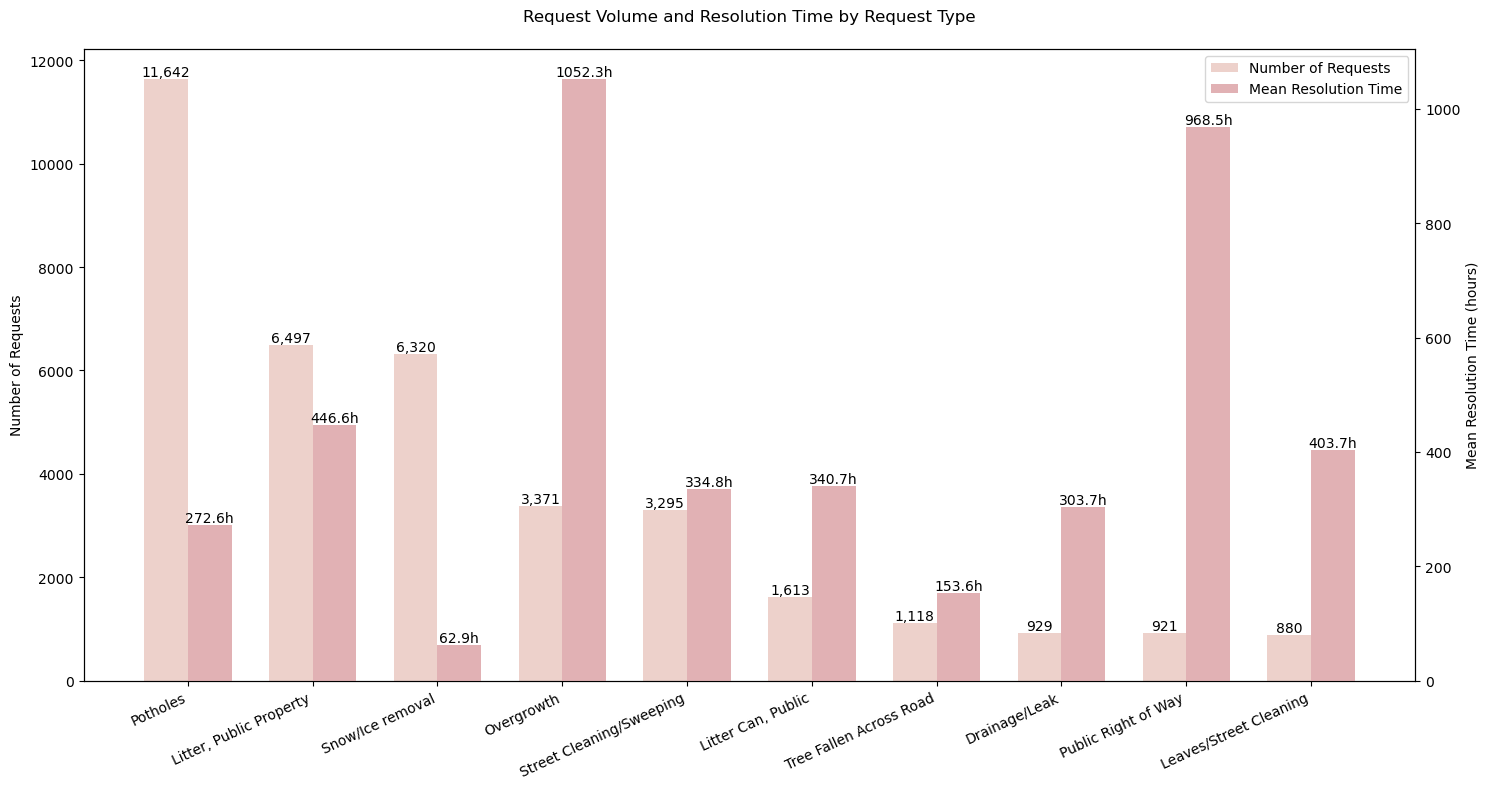

In [9]:
# Create figure with larger size for better readability
fig, ax1 = plt.subplots(figsize=(15, 8))

# Create cubehelix color palette
colors = sns.cubehelix_palette(8)

legend_colors = 'black'

# Get data for both metrics
request_counts = request_type_counts.head(10)
mean_times = resolution_by_type.loc[request_counts.index, 'mean']

# Set width for bars
width = 0.35

# Create positions for bars
positions = np.arange(len(request_counts))

# Create bars for request counts
bars1 = ax1.bar(positions - width/2, request_counts.values, width, 
                label='Number of Requests', color=colors[0])

# Create second y-axis for resolution time
ax2 = ax1.twinx()
bars2 = ax2.bar(positions + width/2, mean_times, width, 
                label='Mean Resolution Time', color=colors[1])

# Add value labels on the bars
for i, bar in enumerate(bars1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{int(bar.get_height()):,}',
             ha='center', va='bottom', rotation=0)

for i, bar in enumerate(bars2):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f'{bar.get_height():.1f}h',
             ha='center', va='bottom', rotation=0)

# Customize the plot
ax1.set_xticks(positions)
ax1.set_xticklabels(request_counts.index, rotation=25, ha='right')
ax1.set_ylabel('Number of Requests', color=legend_colors)
ax2.set_ylabel('Mean Resolution Time (hours)', color=legend_colors)

# Set colors for y-axis labels
ax1.tick_params(axis='y', labelcolor=legend_colors)
ax2.tick_params(axis='y', labelcolor=legend_colors)

# Add title and adjust layout
plt.title('Request Volume and Resolution Time by Request Type', pad=20)

# Add legends with black text
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
leg = ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Set legend text color to black
plt.setp(leg.get_texts(), color='black')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

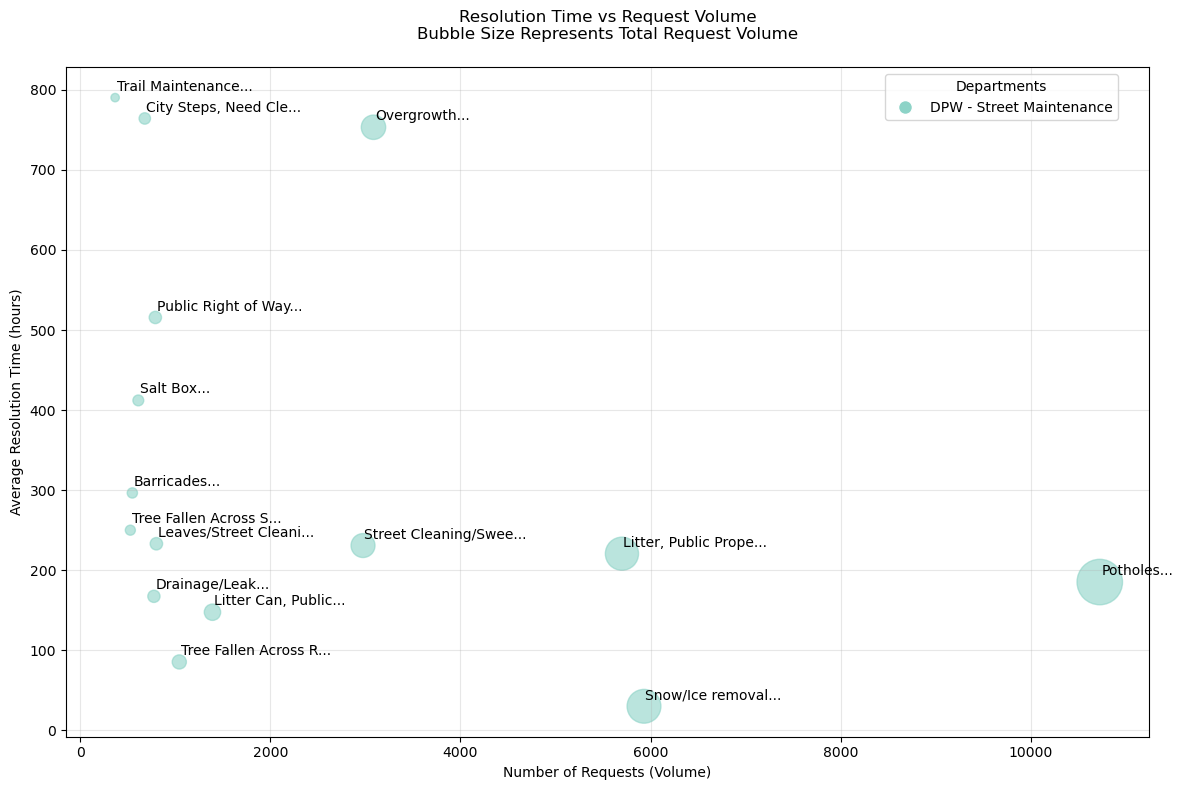


Key Statistics by Department:
--------------------------------------------------

DPW - Street Maintenance:
Average Resolution Time: 338.8 hours
Total Requests: 35,947


In [10]:
# Create the scatter plot with department colors and sized bubbles
plt.figure(figsize=(12, 8))

# Get department info for each request type
request_dept_map = df.groupby('request_type_name')['dept'].agg(lambda x: x.value_counts().index[0])

# Calculate statistics
resolution_stats = filtered_data.groupby('request_type_name').agg({
    'resolution_time': ['mean', 'count']
}).droplevel(0, axis=1)
resolution_stats.columns = ['mean_time', 'count']
resolution_stats = resolution_stats.sort_values('count', ascending=False).head(15)

# Add department information
resolution_stats['department'] = resolution_stats.index.map(request_dept_map)

# Create color map for departments
departments = resolution_stats['department'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(departments)))
dept_color_map = dict(zip(departments, colors))

# Create scatter plot with sized bubbles and department colors
scatter = plt.scatter(resolution_stats['count'], 
                     resolution_stats['mean_time'],
                     s=resolution_stats['count']/10,  # Size circles based on count
                     alpha=0.6,
                     c=[dept_color_map[d] for d in resolution_stats['department']],
                     label=resolution_stats['department'])

# Add labels for points
for idx, row in resolution_stats.iterrows():
    plt.annotate(idx[:20] + '...', 
                (row['count'], row['mean_time']),
                xytext=(1, 5), textcoords='offset points',
                fontsize=10)

# Create custom legend for departments
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=dept, markersize=10)
                  for dept, color in dept_color_map.items()]
plt.legend(handles=legend_elements, title='Departments', 
          bbox_to_anchor=(0.75, 1), loc='upper left')

# Add labels and title
plt.xlabel('Number of Requests (Volume)')
plt.ylabel('Average Resolution Time (hours)')
plt.title('Resolution Time vs Request Volume\nBubble Size Represents Total Request Volume', 
         fontsize=12, pad=20)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print("\nKey Statistics by Department:")
print("-" * 50)
for dept in departments:
    dept_stats = resolution_stats[resolution_stats['department'] == dept]
    print(f"\n{dept}:")
    print(f"Average Resolution Time: {dept_stats['mean_time'].mean():.1f} hours")
    print(f"Total Requests: {dept_stats['count'].sum():,}")

### 3. SPATIAL

In [11]:
df['city'].value_counts()

city
Pittsburgh        40472
Homestead            57
Munhall              23
Carnegie             21
Mount Oliver          6
Green Tree            4
Crafton               4
Ingram                3
West Homestead        3
Millvale              3
Swissvale             2
ARSENAL               2
West Mifflin          2
Avalon                1
Pitcairn              1
Stowe Township        1
Penn Hills            1
Name: count, dtype: int64

In [ ]:
df['neighborhood'].value_counts()

neighborhood
Brookline                    2019
Squirrel Hill South          1764
Carrick                      1654
Central Business District    1270
Bloomfield                   1236
                             ... 
East Carnegie                  39
St. Clair                      37
Glen Hazel                     19
Arlington Heights              15
Mount Oliver Borough            3
Name: count, Length: 91, dtype: int64

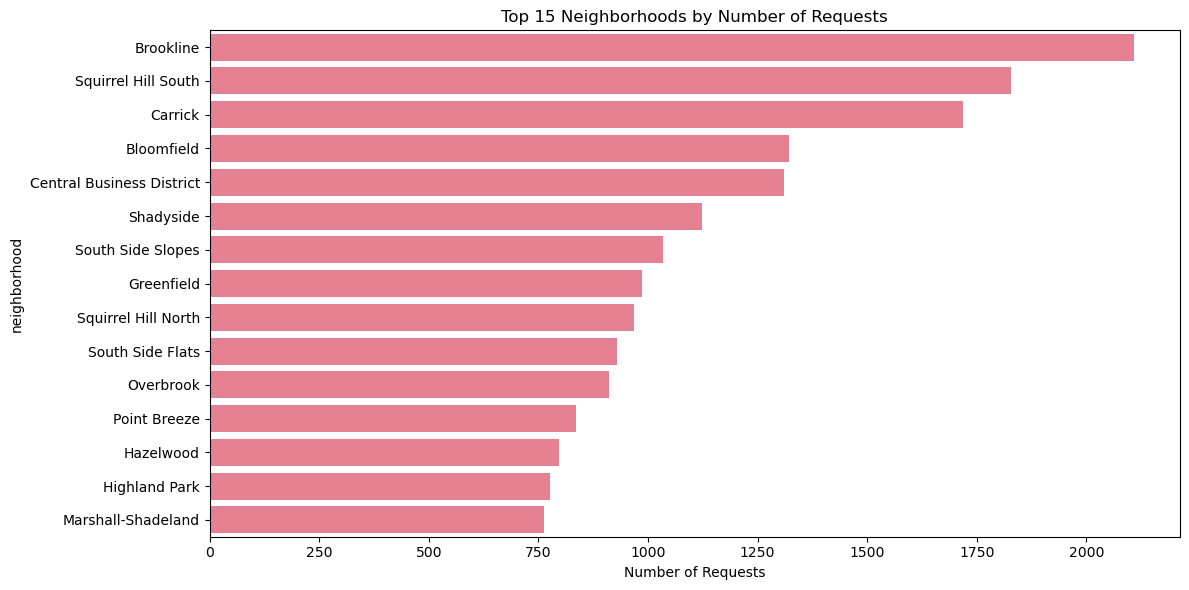


Neighborhood Statistics:
                           request_count  avg_resolution_time  \
neighborhood                                                    
Brookline                           2108               270.34   
Squirrel Hill South                 1828               246.99   
Carrick                             1719               257.19   
Bloomfield                          1321               452.00   
Central Business District           1309               252.55   
Shadyside                           1122               472.73   
South Side Slopes                   1035               296.41   
Greenfield                           987               241.79   
Squirrel Hill North                  968               160.40   
South Side Flats                     930               299.23   

                           median_resolution_time  
neighborhood                                       
Brookline                                   93.93  
Squirrel Hill South                  

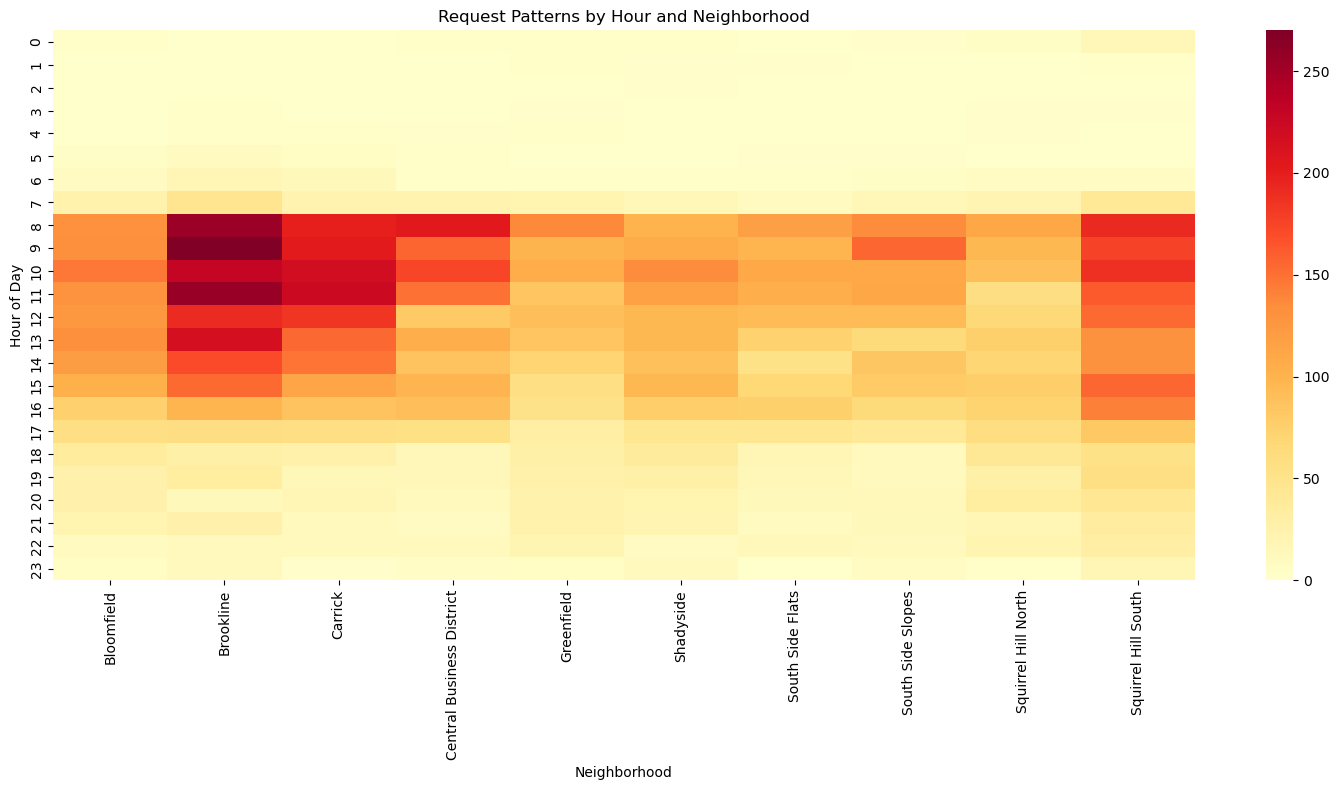

In [12]:
# 1. First let's analyze requests by neighborhood
neighborhood_counts = df['neighborhood'].value_counts()

# Visualize top 15 neighborhoods
plt.figure(figsize=(12, 6))
sns.barplot(x=neighborhood_counts.head(15).values, 
            y=neighborhood_counts.head(15).index)
plt.title('Top 15 Neighborhoods by Number of Requests')
plt.xlabel('Number of Requests')
plt.tight_layout()
plt.show()

# 2. Create an interactive map
# First, clean the latitude/longitude data
valid_coords = df[
    (df['latitude'].notna()) & 
    (df['longitude'].notna()) &
    (df['geo_accuracy'] != 'NULL_COORDINATES') &
    (df['geo_accuracy'] != 'OUT_OF_BOUNDS')
]

# Create base map centered on Pittsburgh
m = folium.Map(
    location=[40.4406, -79.9959],  # Pittsburgh coordinates
    zoom_start=12
)

# Add heatmap layer
heat_data = [[row['latitude'], row['longitude']] for idx, row in valid_coords.iterrows()]
HeatMap(heat_data).add_to(m)

# Save the map
m.save('pittsburgh_requests_heatmap.html')

# 3. Analyze request density by neighborhood
neighborhood_stats = df.groupby('neighborhood').agg({
    '_id': 'count',
    'resolution_time': ['mean', 'median']
}).round(2)

neighborhood_stats.columns = ['request_count', 'avg_resolution_time', 'median_resolution_time']
neighborhood_stats = neighborhood_stats.sort_values('request_count', ascending=False)

print("\nNeighborhood Statistics:")
print(neighborhood_stats.head(10))

# 4. Time of day analysis by neighborhood
df['hour'] = df['create_date_et'].dt.hour

# Create heatmap of requests by hour and top 10 neighborhoods
plt.figure(figsize=(15, 8))
top_10_neighborhoods = neighborhood_counts.head(10).index
hourly_neighborhood = pd.crosstab(
    df[df['neighborhood'].isin(top_10_neighborhoods)]['hour'],
    df[df['neighborhood'].isin(top_10_neighborhoods)]['neighborhood']
)

sns.heatmap(hourly_neighborhood, cmap='YlOrRd')
plt.title('Request Patterns by Hour and Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()


Import Map from geojson

In [19]:
import requests
import json
from pathlib import Path

# Download the GeoJSON data
url = "https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/pittsburghpaneighborhoods-.geojson"
response = requests.get(url)
neighborhoods = response.json()

# Create directory if it doesn't exist
project_root = Path().absolute().parent  # Go up one level from notebooks/
save_dir = project_root / 'data' / 'support'
os.makedirs(save_dir, exist_ok=True)

# Save the file to the correct location
file_path = save_dir / 'pittsburgh_neighborhoods.geojson'
with open(file_path, 'w') as f:
    json.dump(neighborhoods, f)


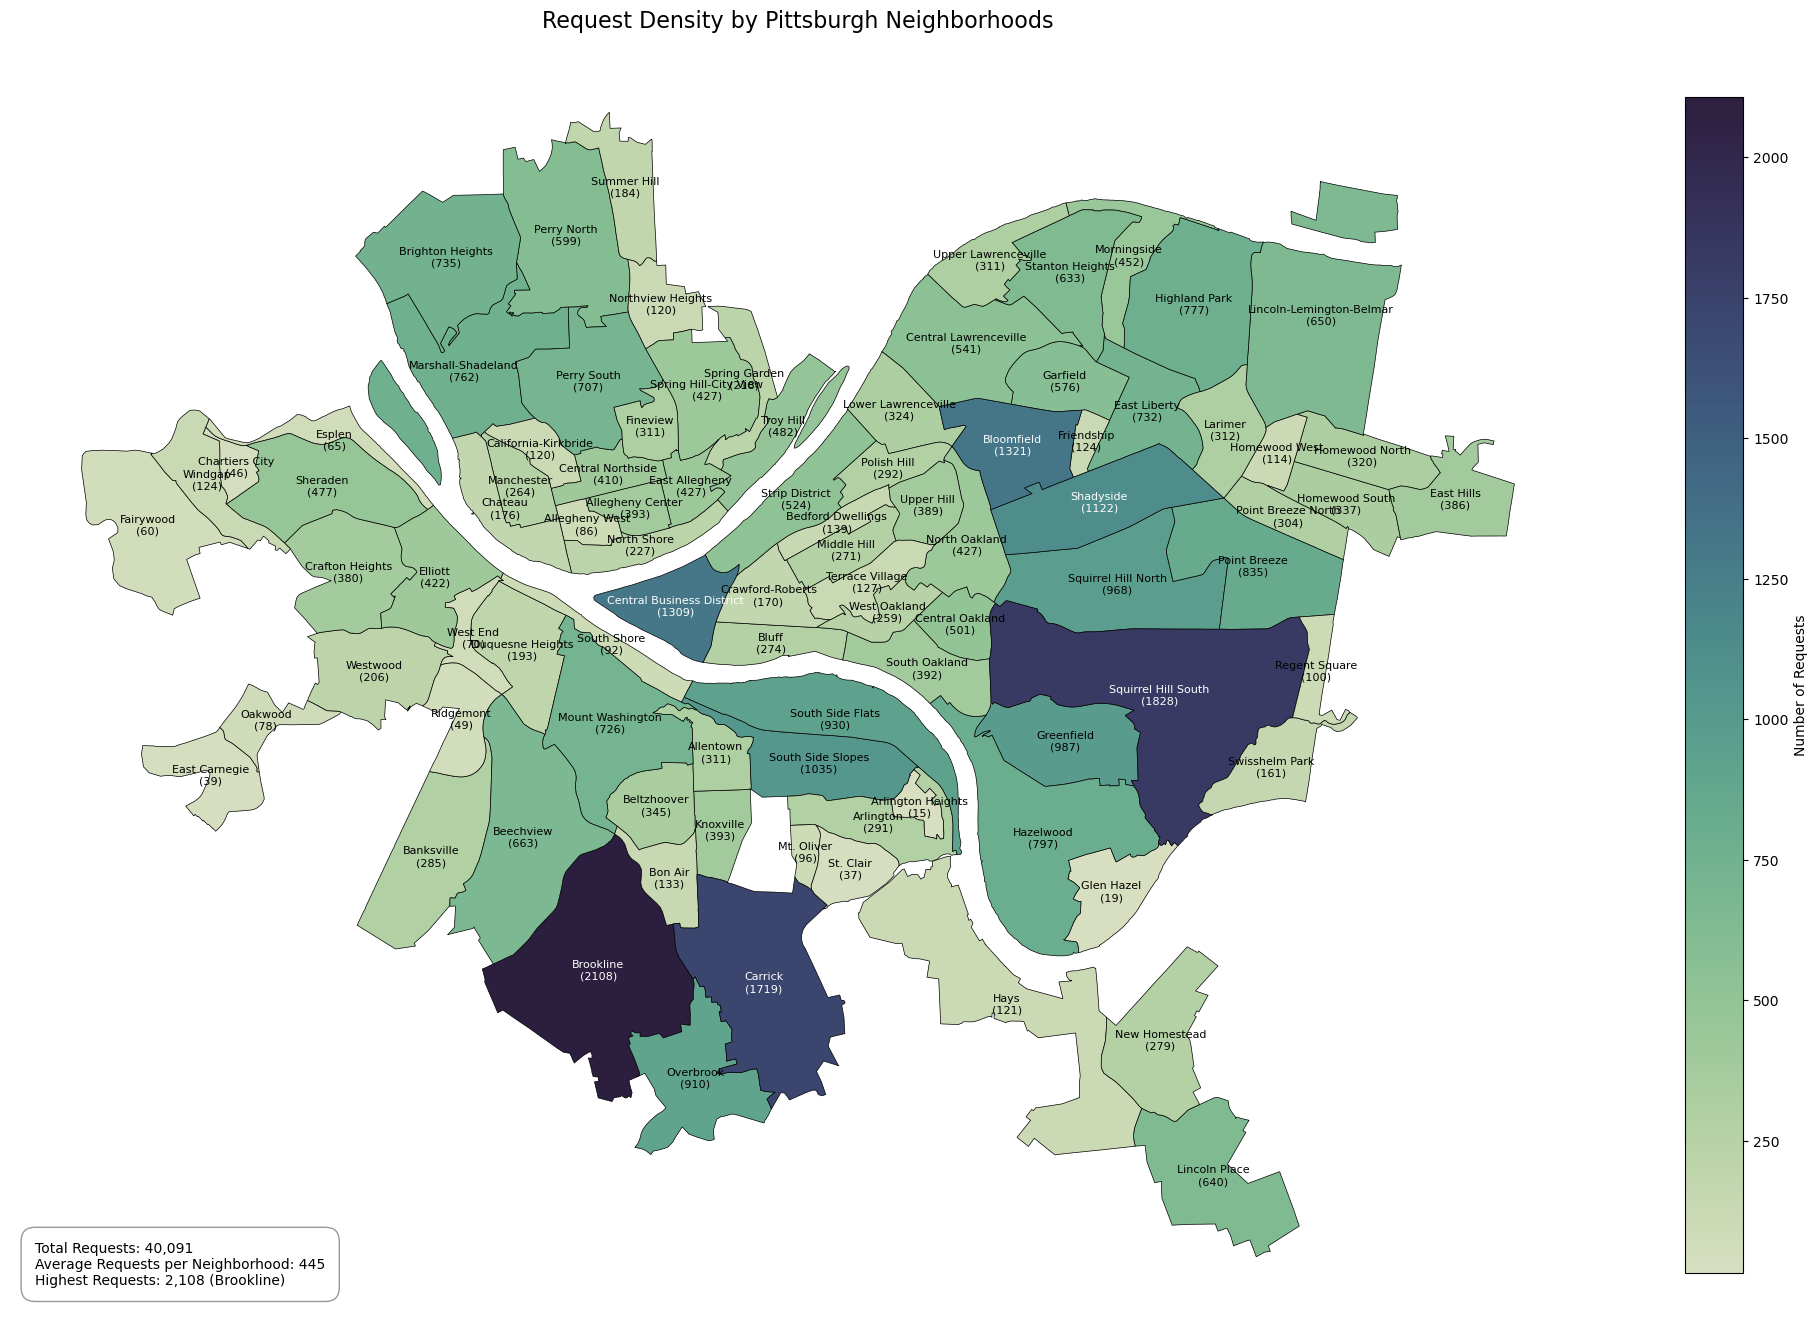

In [20]:
gdf = gpd.read_file(project_root / 'data' / 'support' / 'pittsburgh_neighborhoods.geojson')
    
# Calculate request counts by neighborhood
neighborhood_counts = df['neighborhood'].value_counts().reset_index()
neighborhood_counts.columns = ['neighborhood', 'count']

# Merge and plot
gdf = gdf.merge(neighborhood_counts, 
                left_on='hood',  # adjust this field name if needed
                right_on='neighborhood',
                how='left')

# Create map with enhanced styling using seaborn cubehelix palette
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Create custom cubehelix palette and convert to matplotlib colormap
colors = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)

# Plot with custom cubehelix palette
gdf.plot(column='count', 
        cmap=colors,
        legend=True,
        legend_kwds={'label': 'Number of Requests',
                    'orientation': 'vertical',
                    'shrink': 0.8},
        ax=ax,
        edgecolor='black',
        linewidth=0.5)

# Function to determine text color based on background brightness
def get_text_color(value, vmin, vmax, cmap):
    # Normalize the value
    norm = (value - vmin) / (vmax - vmin)
    # Get the RGB color from colormap
    rgb = cmap(norm)[:3]  # Get RGB values (exclude alpha)
    # Calculate perceived brightness using RGB weights
    brightness = (rgb[0] * 299 + rgb[1] * 587 + rgb[2] * 114) / 1000
    # Return white for dark backgrounds, black for light backgrounds
    return 'white' if brightness < 0.5 else 'black'

# Get min and max values for normalization
vmin = gdf['count'].min()
vmax = gdf['count'].max()

# Add neighborhood labels
for idx, row in gdf.iterrows():
    if not pd.isna(row['count']):  # Only add labels for neighborhoods with data
        centroid = row.geometry.centroid
        # Determine text color based on background
        text_color = get_text_color(row['count'], vmin, vmax, colors)
        ax.annotate(text=f"{row['hood']}\n({int(row['count'])})",
                   xy=(centroid.x, centroid.y),
                   ha='center',
                   va='center',
                   fontsize=8,
                   color=text_color)

# Customize the plot
plt.title('Request Density by Pittsburgh Neighborhoods', 
         fontsize=16, 
         pad=20)
plt.axis('off')

# Add a text box with summary statistics
total_requests = gdf['count'].sum()
avg_requests = gdf['count'].mean()
max_requests = gdf['count'].max()
max_neighborhood = gdf.loc[gdf['count'].idxmax(), 'hood']

stats_text = f"Total Requests: {int(total_requests):,}\n"
stats_text += f"Average Requests per Neighborhood: {int(avg_requests):,}\n"
stats_text += f"Highest Requests: {int(max_requests):,} ({max_neighborhood})"

# Add stats text with white background and slight transparency
plt.figtext(0.02, 0.1, stats_text,
           bbox=dict(facecolor='white',
                    alpha=0.8,
                    edgecolor='gray',
                    boxstyle='round,pad=1'),
           fontsize=10)

plt.tight_layout()
plt.show()